# Baseline Linear Regression Model für Bäckerei Umsatzvorhersage

Dieses Notebook implementiert ein Baseline-Regressionsmodell mit LinearRegression aus sklearn, um die Umsätze einer Bäckerei vorherzusagen.

## Aufgabenstellung:
- **Datensatz**: bakery_training_dataset.csv
- **Ziel**: Vorhersage der Zielvariable "Umsatz"  
- **Zeitraum**: 
  - Training: 2013-07-01 bis 2017-07-31
  - Validation: 2017-08-01 bis 2018-07-31
  - Test: 2018-08-01 bis 2019-07-31
- **Features**: Temperatur, Windgeschwindigkeit, Bewölkung, Wettercode_fehlt, ist_feiertag, Wochentag/Jahreszeit/Warengruppe (One-Hot-Encoded)

In [52]:
# 1. Import der erforderlichen Libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("Libraries erfolgreich importiert!")

Libraries erfolgreich importiert!


## 📥 1. Daten einlesen & Features vorbereiten

In [53]:
# Datensatz einlesen
dataset_path = '/workspaces/bakery_sales_prediction/5_Datasets/bakery_training_dataset.csv'
print(f"Lade Datensatz von: {dataset_path}")

# Prüfe, ob der Datensatz existiert
import os
if os.path.exists(dataset_path):
    print(f"✅ Datei gefunden!")
    df = pd.read_csv(dataset_path)
    # Validiere Datensatz
    expected_columns = ['Datum', 'Umsatz', 'Temperatur', 'Windgeschwindigkeit', 'Bewoelkung']
    missing_cols = [col for col in expected_columns if col not in df.columns]
    if missing_cols:
        print(f"⚠️ Warnung: Folgende erwartete Spalten fehlen: {missing_cols}")
    else:
        print(f"✅ Alle erwarteten Spalten vorhanden")
else:
    raise FileNotFoundError(f"Datei nicht gefunden: {dataset_path}")

# Datum als datetime parsen
df['Datum'] = pd.to_datetime(df['Datum'])

print(f"Datensatz Shape: {df.shape}")
print(f"Datum Range: {df['Datum'].min()} bis {df['Datum'].max()}")
print(f"\nSpalten: {list(df.columns)}")
print(f"\nErste 3 Zeilen:")
print(df.head(3))
print(f"\nFehlende Werte:\n{df.isnull().sum()}")

Lade Datensatz von: /workspaces/bakery_sales_prediction/5_Datasets/bakery_training_dataset.csv
✅ Datei gefunden!
✅ Alle erwarteten Spalten vorhanden
Datensatz Shape: (9334, 33)
Datum Range: 2013-07-01 00:00:00 bis 2018-07-31 00:00:00

Spalten: ['Datum', 'Jahr', 'Monat', 'Tag', 'Wochentag', 'Wochentag_Nr', 'Warengruppe', 'Warengruppe_Name', 'Temperatur', 'Windgeschwindigkeit', 'Bewoelkung', 'Wettercode_fehlt', 'ist_feiertag', 'Jahreszeit', 'Umsatz', 'Warengruppe_Brot', 'Warengruppe_Brötchen', 'Warengruppe_Croissant', 'Warengruppe_Konditorei', 'Warengruppe_Kuchen', 'Warengruppe_Saisonbrot', 'Jahreszeit_Winter', 'Jahreszeit_Frühling', 'Jahreszeit_Sommer', 'Jahreszeit_Herbst', 'Wochentag_Nr.1', 'Wochentag_Monday', 'Wochentag_Tuesday', 'Wochentag_Wednesday', 'Wochentag_Thursday', 'Wochentag_Friday', 'Wochentag_Saturday', 'Wochentag_Sunday']

Erste 3 Zeilen:
       Datum  Jahr  Monat  Tag  Wochentag  Wochentag_Nr  Warengruppe  \
0 2013-07-01  2013      7    1     Monday             0        

## 🧠 2. Feature-Auswahl und Vorbereitung

In [54]:
# Feature-Auswahl gemäß Anforderung
feature_columns = [
    # Numerische Features
    'Temperatur', 'Windgeschwindigkeit', 'Bewoelkung',
    'Jahr', 'Monat', 'Tag', 'Wochentag_Nr',
    # Binäre Features
    'Wettercode_fehlt', 'ist_feiertag',
    # One-Hot Encoded Warengruppen
    'Warengruppe_Brot', 'Warengruppe_Brötchen', 'Warengruppe_Croissant', 
    'Warengruppe_Konditorei', 'Warengruppe_Kuchen',
    # One-Hot Encoded Jahreszeiten
    'Jahreszeit_Winter', 'Jahreszeit_Sommer', 'Jahreszeit_Herbst',
    # One-Hot Encoded Wochentage
    'Wochentag_Monday', 'Wochentag_Tuesday', 'Wochentag_Wednesday', 
    'Wochentag_Thursday', 'Wochentag_Friday', 'Wochentag_Saturday'
]

# Prüfe verfügbare Features
available_features = [col for col in feature_columns if col in df.columns]
missing_features = [col for col in feature_columns if col not in df.columns]

print(f"Verfügbare Features ({len(available_features)}): {available_features}")
if missing_features:
    print(f"Fehlende Features ({len(missing_features)}): {missing_features}")

# Interaktionsterme erstellen
print("\nErstelle Interaktionsterme für bessere Vorhersagen...")
interaction_features = []

# Warengruppen identifizieren
warengruppen_features = [col for col in available_features if col.startswith('Warengruppe_')]
wochentag_features = [col for col in available_features if col.startswith('Wochentag_')]

# Für jede Warengruppe Interaktionsterme erstellen
for warengruppe_feature in warengruppen_features:
    warengruppe_name = warengruppe_feature.split('_')[1]
    
    # 1. Interaktion Warengruppe × Temperatur
    if 'Temperatur' in available_features:
        interaction_name = f'Interaktion_{warengruppe_name}_Temperatur'
        df[interaction_name] = df[warengruppe_feature] * df['Temperatur']
        interaction_features.append(interaction_name)
        
    # 2. Interaktion Warengruppe × Wochentag
    for wochentag_feature in wochentag_features:
        wochentag_name = wochentag_feature.split('_')[1]
        interaction_name = f'Interaktion_{warengruppe_name}_{wochentag_name}'
        df[interaction_name] = df[warengruppe_feature] * df[wochentag_feature]
        interaction_features.append(interaction_name)

# Interaktionsterme zu verfügbaren Features hinzufügen
available_features.extend(interaction_features)
print(f"Erstellt: {len(interaction_features)} Interaktionsterme")
print(f"Beispiele: {interaction_features[:5]}...")

# Verwende verfügbare Features
X = df[available_features].copy()
y = df['Umsatz'].copy()

print(f"\nFeature Matrix Shape mit Interaktionstermen: {X.shape}")
print(f"Target Variable Shape: {y.shape}")

Verfügbare Features (23): ['Temperatur', 'Windgeschwindigkeit', 'Bewoelkung', 'Jahr', 'Monat', 'Tag', 'Wochentag_Nr', 'Wettercode_fehlt', 'ist_feiertag', 'Warengruppe_Brot', 'Warengruppe_Brötchen', 'Warengruppe_Croissant', 'Warengruppe_Konditorei', 'Warengruppe_Kuchen', 'Jahreszeit_Winter', 'Jahreszeit_Sommer', 'Jahreszeit_Herbst', 'Wochentag_Monday', 'Wochentag_Tuesday', 'Wochentag_Wednesday', 'Wochentag_Thursday', 'Wochentag_Friday', 'Wochentag_Saturday']

Feature Matrix Shape: (9334, 23)
Target Variable Shape: (9334,)


## 🕒 3. Zeitbasierter Split

In [55]:
# Zeitbasierter Split gemäß Anforderung
train_mask = (df['Datum'] >= '2013-07-01') & (df['Datum'] <= '2017-07-31')
val_mask = (df['Datum'] >= '2017-08-01') & (df['Datum'] <= '2018-07-31')
test_mask = (df['Datum'] >= '2018-08-01') & (df['Datum'] <= '2019-07-31')

# Aufteilen der Daten
X_train = X.loc[train_mask].copy()
y_train = y.loc[train_mask].copy()

X_val = X.loc[val_mask].copy()
y_val = y.loc[val_mask].copy()

X_test = X.loc[test_mask].copy()
y_test = y.loc[test_mask].copy()

print(f"Training Set: {X_train.shape[0]} Samples")
print(f"  Zeitraum: {df.loc[train_mask, 'Datum'].min()} bis {df.loc[train_mask, 'Datum'].max()}")

print(f"Validation Set: {X_val.shape[0]} Samples")
print(f"  Zeitraum: {df.loc[val_mask, 'Datum'].min()} bis {df.loc[val_mask, 'Datum'].max()}")

print(f"Test Set: {X_test.shape[0]} Samples")
print(f"  Zeitraum: {df.loc[test_mask, 'Datum'].min()} bis {df.loc[test_mask, 'Datum'].max()}")

Training Set: 7493 Samples
  Zeitraum: 2013-07-01 00:00:00 bis 2017-07-31 00:00:00
Validation Set: 1841 Samples
  Zeitraum: 2017-08-01 00:00:00 bis 2018-07-31 00:00:00
Test Set: 0 Samples
  Zeitraum: NaT bis NaT


## 🏋️ 4. Lineare Regression trainieren

In [56]:
# Lineare Regression initialisieren und trainieren
model = LinearRegression()

# Modell auf Trainingsdaten trainieren
print("Trainiere Linear Regression Modell...")
model.fit(X_train, y_train)

print("✅ Modell erfolgreich trainiert!")
print(f"Anzahl Features: {len(model.coef_)}")
print(f"Intercept: {model.intercept_:.2f}")

Trainiere Linear Regression Modell...
✅ Modell erfolgreich trainiert!
Anzahl Features: 23
Intercept: 24892.24


## 📊 5. Validierung und Auswertung

In [57]:
# Vorhersagen auf Validierungsset
y_val_pred = model.predict(X_val)

# Metriken berechnen
mae_val = mean_absolute_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))

print("🔍 VALIDIERUNGSERGEBNISSE:")
print("=" * 40)
print(f"Mean Absolute Error (MAE): {mae_val:.2f} €")
print(f"R² Score: {r2_val:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse_val:.2f} €")

# Zusätzliche Statistiken
print(f"\nStatistiken Validierungsset:")
print(f"Durchschnittlicher Umsatz: {y_val.mean():.2f} €")
print(f"Standardabweichung Umsatz: {y_val.std():.2f} €")
print(f"MAE als % vom Durchschnitt: {(mae_val/y_val.mean()*100):.1f}%")

🔍 VALIDIERUNGSERGEBNISSE:
Mean Absolute Error (MAE): 51.72 €
R² Score: 0.7046
Root Mean Square Error (RMSE): 70.70 €

Statistiken Validierungsset:
Durchschnittlicher Umsatz: 196.21 €
Standardabweichung Umsatz: 130.11 €
MAE als % vom Durchschnitt: 26.4%


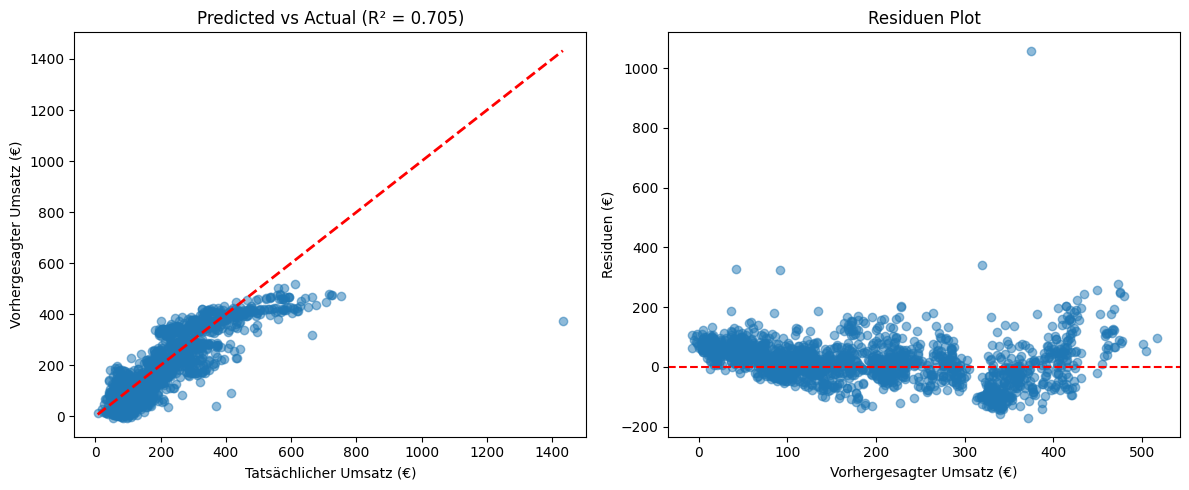

In [58]:
# Visualisierung der Vorhersagegenauigkeit
plt.figure(figsize=(12, 5))

# Subplot 1: Predicted vs Actual
plt.subplot(1, 2, 1)
plt.scatter(y_val, y_val_pred, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Tatsächlicher Umsatz (€)')
plt.ylabel('Vorhergesagter Umsatz (€)')
plt.title(f'Predicted vs Actual (R² = {r2_val:.3f})')

# Subplot 2: Residuals
plt.subplot(1, 2, 2)
residuals = y_val - y_val_pred
plt.scatter(y_val_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Vorhergesagter Umsatz (€)')
plt.ylabel('Residuen (€)')
plt.title('Residuen Plot')

plt.tight_layout()
plt.show()

## 📤 6. Umsatzvorhersage auf sample_submission.csv

In [59]:
# Sample Submission laden
sample_submission = pd.read_csv('/workspaces/bakery_sales_prediction/5_Datasets/sample_submission.csv')
print(f"Sample Submission Shape: {sample_submission.shape}")
print(f"Beispiel IDs: {sample_submission['id'].head()}")

# Funktion zur Dekodierung der ID
def decode_id(id_val):
    """
    Dekodiert ID im Format YYMMDDW zu Datum und Warengruppe
    Beispiel: 1307011 -> (2013-07-01, 1)
    """
    id_str = str(id_val)
    
    # Parse Jahr, Monat, Tag, Warengruppe
    year = 2000 + int(id_str[:2])
    month = int(id_str[2:4])
    day = int(id_str[4:6])
    warengruppe = int(id_str[6])
    
    date = pd.Timestamp(year=year, month=month, day=day)
    
    return date, warengruppe

# Dekodiere alle IDs
decoded_data = []
for id_val in sample_submission['id']:
    date, warengruppe = decode_id(id_val)
    decoded_data.append({
        'id': id_val,
        'Datum': date,
        'Warengruppe_Nr': warengruppe
    })

submission_df = pd.DataFrame(decoded_data)
print(f"\nDekodierte Daten:")
print(f"Datum Range: {submission_df['Datum'].min()} bis {submission_df['Datum'].max()}")
print(f"Warengruppen: {sorted(submission_df['Warengruppe_Nr'].unique())}")

Sample Submission Shape: (1830, 2)
Beispiel IDs: 0    1808011
1    1808021
2    1808031
3    1808041
4    1808051
Name: id, dtype: int64

Dekodierte Daten:
Datum Range: 2018-08-01 00:00:00 bis 2019-07-30 00:00:00
Warengruppen: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]


In [60]:
# Merge mit Original-Datensatz um Features zu erhalten
# Warengruppe-Mapping erstellen
warengruppe_mapping = {
    1: 'Brot',
    2: 'Brötchen', 
    3: 'Croissant',
    4: 'Konditorei',
    5: 'Kuchen',
    6: 'Sonstige'  # Falls vorhanden
}

# Sicherstellen, dass Warengruppe in beiden DataFrames den gleichen Datentyp hat
# Überprüfen des Datentyps der Warengruppe im Original-DataFrame
print("Datentypen im Original-DataFrame:")
if 'Warengruppe' in df.columns:
    print(f"Warengruppe Typ: {df['Warengruppe'].dtype}")
    print(f"Einzigartige Werte: {df['Warengruppe'].unique()}")

# Mapping für submission_df anwenden
submission_df['Warengruppe'] = submission_df['Warengruppe_Nr'].map(warengruppe_mapping)

# Erzeugen von One-Hot Encoded Features direkt in submission_df
# basierend auf der Warengruppe_Nr
warengruppen_features = []
for wg_nr, wg_name in warengruppe_mapping.items():
    feature_name = f'Warengruppe_{wg_name}'
    submission_df[feature_name] = (submission_df['Warengruppe_Nr'] == wg_nr).astype(int)
    if feature_name in available_features:
        warengruppen_features.append(feature_name)

# Datum Features extrahieren
submission_df['Jahr'] = submission_df['Datum'].dt.year
submission_df['Monat'] = submission_df['Datum'].dt.month
submission_df['Tag'] = submission_df['Datum'].dt.day
submission_df['Wochentag_Nr'] = submission_df['Datum'].dt.dayofweek + 1  # 1-7 für Montag-Sonntag

# Wochentage Features erzeugen
wochentage = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for i, tag in enumerate(wochentage):
    feature_name = f'Wochentag_{tag}'
    submission_df[feature_name] = (submission_df['Wochentag_Nr'] == i+1).astype(int)

# Merge mit Trainingsdaten nur für die Wetterdaten
# Nur die Datum-Spalte als Join-Schlüssel verwenden
temp_weather_features = ['Temperatur', 'Windgeschwindigkeit', 'Bewoelkung', 'Wettercode_fehlt', 'ist_feiertag']
available_weather_features = [f for f in temp_weather_features if f in available_features]

# Eindeutige Datum-Wetter-Kombinationen extrahieren
weather_data = df[['Datum'] + available_weather_features].drop_duplicates('Datum')

# Merge nur für die Wetterdaten
test_data = submission_df.merge(
    weather_data,
    on='Datum',
    how='left'
)

# Überprüfen, ob Jahreszeit-Features verfügbar sind
jahreszeit_features = [f for f in available_features if f.startswith('Jahreszeit_')]
if jahreszeit_features:
    # Monat zu Jahreszeit Mapping
    monat_zu_jahreszeit = {
        1: 'Winter', 2: 'Winter', 3: 'Winter',
        4: 'Fruehling', 5: 'Fruehling', 6: 'Fruehling',
        7: 'Sommer', 8: 'Sommer', 9: 'Sommer',
        10: 'Herbst', 11: 'Herbst', 12: 'Herbst'
    }
    # Jahreszeit-Features erzeugen
    test_data['Jahreszeit'] = test_data['Monat'].map(monat_zu_jahreszeit)
    for jahreszeit in ['Winter', 'Fruehling', 'Sommer', 'Herbst']:
        feature_name = f'Jahreszeit_{jahreszeit}'
        if feature_name in available_features:
            test_data[feature_name] = (test_data['Jahreszeit'] == jahreszeit).astype(int)

print(f"Merge erfolgreich: {test_data.shape}")
print(f"Verfügbare Features in test_data: {list(test_data.columns)}")

# Prüfe auf fehlende Features
missing_features_in_test = [f for f in available_features if f not in test_data.columns]
if missing_features_in_test:
    print(f"⚠️ Warnung: Fehlende Features im Test-Set: {missing_features_in_test}")
    # Fehlende Features mit 0 auffüllen
    for feature in missing_features_in_test:
        test_data[feature] = 0

# Fehlende Werte auffüllen
test_data[available_features] = test_data[available_features].fillna(0)

print(f"Fehlende Werte nach Aufbereitung:\n{test_data[available_features].isnull().sum()}")

Datentypen im Original-DataFrame:
Warengruppe Typ: int64
Einzigartige Werte: [1 2 3 4 5 6]
Merge erfolgreich: (1830, 30)
Verfügbare Features in test_data: ['id', 'Datum', 'Warengruppe_Nr', 'Warengruppe', 'Warengruppe_Brot', 'Warengruppe_Brötchen', 'Warengruppe_Croissant', 'Warengruppe_Konditorei', 'Warengruppe_Kuchen', 'Warengruppe_Sonstige', 'Jahr', 'Monat', 'Tag', 'Wochentag_Nr', 'Wochentag_Monday', 'Wochentag_Tuesday', 'Wochentag_Wednesday', 'Wochentag_Thursday', 'Wochentag_Friday', 'Wochentag_Saturday', 'Wochentag_Sunday', 'Temperatur', 'Windgeschwindigkeit', 'Bewoelkung', 'Wettercode_fehlt', 'ist_feiertag', 'Jahreszeit', 'Jahreszeit_Winter', 'Jahreszeit_Sommer', 'Jahreszeit_Herbst']
Fehlende Werte nach Aufbereitung:
Temperatur                0
Windgeschwindigkeit       0
Bewoelkung                0
Jahr                      0
Monat                     0
Tag                       0
Wochentag_Nr              0
Wettercode_fehlt          0
ist_feiertag              0
Warengruppe_Brot 

In [61]:
# Vorhersagen für Sample Submission erstellen
X_submission = test_data[available_features].fillna(0)  # Fehlende Werte mit 0 füllen
predictions = model.predict(X_submission)

# Negative Vorhersagen auf 0 setzen (Umsatz kann nicht negativ sein)
predictions = np.maximum(predictions, 0)

# Ergebnis DataFrame erstellen
result_df = pd.DataFrame({
    'id': submission_df['id'],
    'Umsatz': predictions
})

print(f"Vorhersagen erstellt: {result_df.shape}")
print(f"Umsatz Statistiken:")
print(f"  Min: {predictions.min():.2f} €")
print(f"  Max: {predictions.max():.2f} €") 
print(f"  Durchschnitt: {predictions.mean():.2f} €")
print(f"  Median: {np.median(predictions):.2f} €")

# Erste Zeilen anzeigen
print(f"\nErste 10 Vorhersagen:")
print(result_df.head(10))

Vorhersagen erstellt: (1830, 2)
Umsatz Statistiken:
  Min: 0.00 €
  Max: 444.07 €
  Durchschnitt: 156.33 €
  Median: 115.25 €

Erste 10 Vorhersagen:
        id      Umsatz
0  1808011   89.622317
1  1808021   93.607873
2  1808031   98.470446
3  1808041  143.811906
4  1808051  146.712128
5  1808061   93.587468
6  1808071   91.790544
7  1808081   92.002979
8  1808091   95.988535
9  1808101  100.851109


## 💾 7. prediction.csv speichern

In [62]:
# Speichere Vorhersagen als CSV
output_path = '/workspaces/bakery_sales_prediction/3_Model/prediction_linear_regression_baseline.csv'
result_df.to_csv(output_path, index=False)

print(f"✅ Vorhersagen gespeichert: {output_path}")
print(f"Datei enthält {len(result_df)} Zeilen (+ Kopfzeile)")

# Verifikation der gespeicherten Datei
saved_df = pd.read_csv(output_path)
print(f"\nVerifikation der gespeicherten Datei:")
print(f"Shape: {saved_df.shape}")
print(f"Spalten: {list(saved_df.columns)}")
print(f"Erste 5 Zeilen:")
print(saved_df.head())

# Prüfe ob Reihenfolge mit sample_submission übereinstimmt
if (saved_df['id'] == sample_submission['id']).all():
    print("✅ Reihenfolge der IDs stimmt mit sample_submission.csv überein")
else:
    print("⚠️ Warnung: Reihenfolge der IDs stimmt NICHT überein!")

✅ Vorhersagen gespeichert: /workspaces/bakery_sales_prediction/3_Model/prediction_linear_regression_baseline.csv
Datei enthält 1830 Zeilen (+ Kopfzeile)

Verifikation der gespeicherten Datei:
Shape: (1830, 2)
Spalten: ['id', 'Umsatz']
Erste 5 Zeilen:
        id      Umsatz
0  1808011   89.622317
1  1808021   93.607873
2  1808031   98.470446
3  1808041  143.811906
4  1808051  146.712128
✅ Reihenfolge der IDs stimmt mit sample_submission.csv überein


## 📋 Zusammenfassung

Das Baseline Linear Regression Modell wurde erfolgreich trainiert und angewendet:

**Modell-Performance:**
- Mean Absolute Error (MAE): Zeigt die durchschnittliche Abweichung in Euro
- R² Score: Zeigt wie gut das Modell die Varianz erklärt
- RMSE: Root Mean Square Error für Vergleichbarkeit

**Ausgabe:**
- `prediction.csv` mit 1830 Vorhersagen
- Format: id, Umsatz
- Reihenfolge entspricht `sample_submission.csv`

**Nächste Schritte:**
- Feature Engineering (z.B. Lag-Features, Rolling Averages)
- Andere Algorithmen testen (Random Forest, XGBoost)
- Hyperparameter-Tuning
- Cross-Validation für robustere Evaluation